# HW06: Inverse Kinematics

In [1]:
import transforms as tr
import transforms_symbolic as st
import kinematics as kin
import kinematics_symbolic as kins
import time

import numpy as np
import sympy as sm
from IPython.display import display, Math
from sympy.physics.vector.printing import vlatex

from visualization import VizScene 

np.set_printoptions(precision=4, suppress=True)

## Problem 1

Using the Jacobian for the 2-link manipulator shown below, assume each link length is 1, and find the required torques to apply a force in the following directions at the following joint configurations (make note of anything that you think is interesting or increases your understanding). How do your answers change if the force given is a reaction force instead of a force applied by the end-effector?:

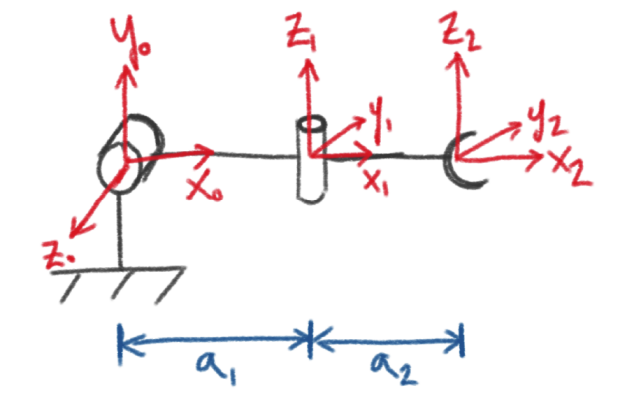

(a) $q = [0, \pi/4], \; F = [-1,0,0] \; \text{Newtons}$

(b) $q = [0, \pi/2], \; F = [-1,0,0] \; \text{Newtons}$

(c) $q = [\pi/4, \pi/4], \; F = [-1,-1,0] \; \text{Newtons}$

(d) $q = [0, 0], \; F = [0,0,1] \; \text{Newtons}$

(e) $q = [0, 0], \; F = [1,0,0] \; \text{Newtons}$

In [2]:
dh1 = [[0, 0, 1, -np.pi/2.0],
       [0, 0, 1, 0]]

q1 = [[0, np.pi/4],
      [0, np.pi/2],
      [np.pi/4, np.pi/4],
      [0, 0],
      [0, 0]]

F1 = np.array([[-1, 0, 0, 0, 0, 0],
               [-1, 0, 0, 0, 0, 0],
               [-1, -1, 0, 0, 0, 0],
               [0, 0, 1, 0, 0, 0],
               [1, 0, 0, 0, 0, 0]])

arm1 = kin.SerialArm(dh1)
print(arm1)


Serial Arm
DH PARAMS
theta	|	d	|	a	|	alpha	|	type
------------------------------------------------------------------------
0	|	0	|	1	|	-1.5708	|	r
0	|	0	|	1	|	0	|	r



In [3]:
# define jacobian for all arms, and the 
J1 = [arm1.jacob(q1[i]) for i in range(len(q1))]

print('joint forces for the arm:')
tau1 = [J1[i].T @ F1[i] for i in range(len(J1))]

labels = ['a', 'b', 'c', 'd', 'e']
for joint in range(len(tau1)):
    print('    joint ' + str(labels[joint]) + ': ' + str(tau1[joint]))

joint forces for the arm:
    joint a: [0.     0.7071]
    joint b: [0. 1.]
    joint c: [0. 1.]
    joint d: [ 0. -1.]
    joint e: [0. 0.]


In [4]:
# find joint torques if loads are reaction forces instead
# reaction forces mean all elements of forces are negative

tau1 = [J1[i].T @ (-1*F1[i]) for i in range(len(J1))]

print('joint forces for the arm if forces are reaction forces:')
for joint in range(len(tau1)):
    print('    joint ' + str(labels[joint]) + ': ' + str(tau1[joint]))

print('\nYou can see that the torques work out to be negative of the original values.')

joint forces for the arm if forces are reaction forces:
    joint a: [-0.     -0.7071]
    joint b: [-0. -1.]
    joint c: [ 0. -1.]
    joint d: [0. 1.]
    joint e: [0. 0.]

You can see that the torques work out to be negative of the original values.


## Problem 2

Vizualizing the configuration of a robot can be very helpful when implementing inverse
kinematics, path planning, and even control algorithms. To help you with the next problems
in this homework, start by doing the following:

### (a) 

Define a new a robot using the following DH parameters for a 6 DoF robot (this is the
robot from HW 3, problem 2(g)):

$$
\begin{array}{|c|c|c|c|c|}
\hline
\text{Link} & \theta_i & d_i & a_i & \alpha_i \\
\hline
1 & q_1 & 0.2 & 0 & -\frac{\pi}{2} \\
2 & q_2 & 0 & 0.2 & 0 \\
3 & q_3 + \frac{\pi}{2} & 0 & 0 & \frac{\pi}{2} \\
4 & q_4 + \frac{\pi}{2} & 0.4 & 0 & -\frac{\pi}{2} \\
5 & q_5 & 0 & 0 & \frac{\pi}{2} \\
6 & q_6 & 0.4 & 0 & 0 \\
\hline
\end{array}
$$

---

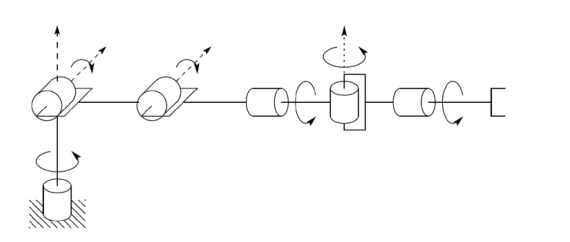

In [5]:
# defien dh parameters and make an arm
dh2 = [[0, 0.2, 0, -np.pi/2.0],
       [0, 0, 0.2, 0],
       [np.pi/2.0, 0, 0, np.pi/2.0],
       [np.pi/2.0, 0.4, 0, -np.pi/2.0],
       [0, 0, 0, np.pi/2.0],
       [0, 0.4, 0, 0]]

Ttip = tr.se3(tr.roty(-np.pi/2), [0,0,0])

arm2 = kin.SerialArm(dh2, tip=Ttip)
print(arm2)

Serial Arm
DH PARAMS
theta	|	d	|	a	|	alpha	|	type
------------------------------------------------------------------------
0	|	0.2000	|	0	|	-1.5708	|	r
0	|	0	|	0.2000	|	0	|	r
1.5708	|	0	|	0	|	1.5708	|	r
1.5708	|	0.4000	|	0	|	-1.5708	|	r
0	|	0	|	0	|	1.5708	|	r
0	|	0.4000	|	0	|	0	|	r



### (b)

Assuming we have already defined a SerialArm called “arm” we can visualize this
robot by implementing the following code:


```
from visualization import VizScene
viz = VizScene()
viz.addarm(arm)
q = [0, 0, 0, 0, 0, 0]
viz.update(qs=[q])
viz.hold()
```

---

In [6]:
# uncomment cell to run
# viz = VizScene()
# viz.add_arm(arm2)
# q = [0, 0, 0, 0, 0, 0]
# viz.update(qs=[q])
# viz.hold()
# viz.close_viz()

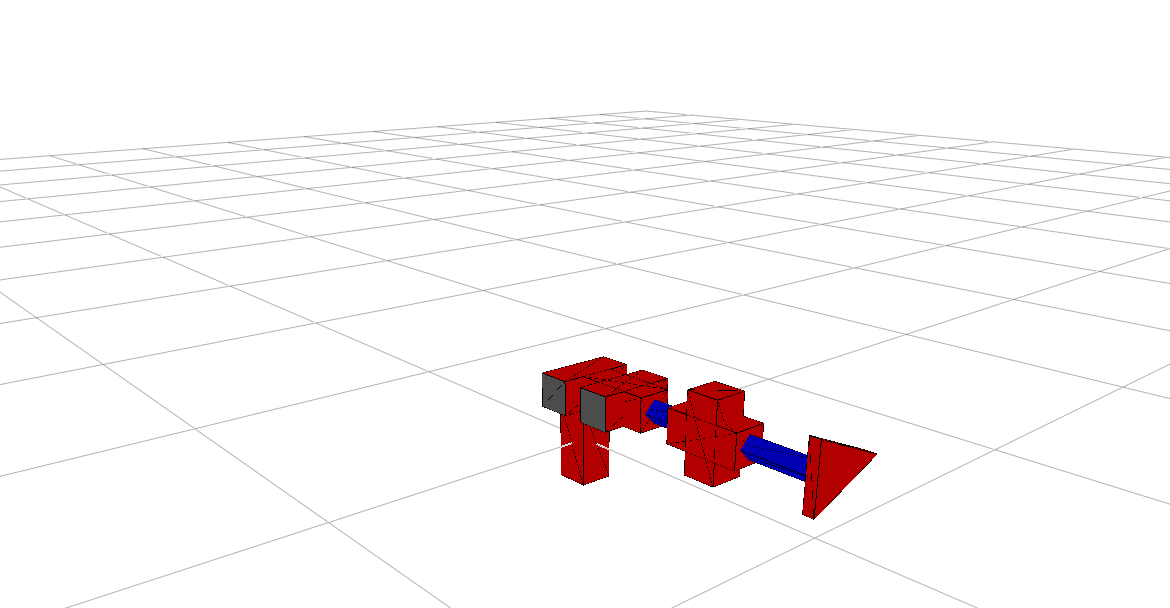

### (c) 

In preparation for the next problem, it will also be useful to visualize a 3D location
to see if your robot tip is moving towards that position. We can use the “add marker”
function that is also part of the ```VizScene``` class in ```visualization.py```. The function
simply takes a list that represents position as follows:

```
goal = [0.1, 0.1, 0.1]  # for x, y, z position
viz.add_marker(goal)
viz.hold()
```

In the prior two examples, ```viz.hold()``` was used instead of a loop. But if we use a loop
and want to update our joint variables, or goal marker, they can be updated as follows:

``` viz.update(qs=[q_new], poss=[goal_new])```

Test this functionality by calculating your forward kinematics for any configuration of
the arm, plot the arm in that configuration, and the green sphere at the tip position. Turn
in a screen shot for your homework.

---

In [7]:
# goal = [0.1, 0.1, 0.1] # for x, y z position
# q = [0, 0, 0, 0, 0, 0]
# goal = arm2.fk(q)[0:3,3]

# viz = VizScene()
# viz.add_arm(arm2)
# viz.add_marker(goal)
# viz.update(qs=[q])
# viz.hold()
# viz.close_viz()

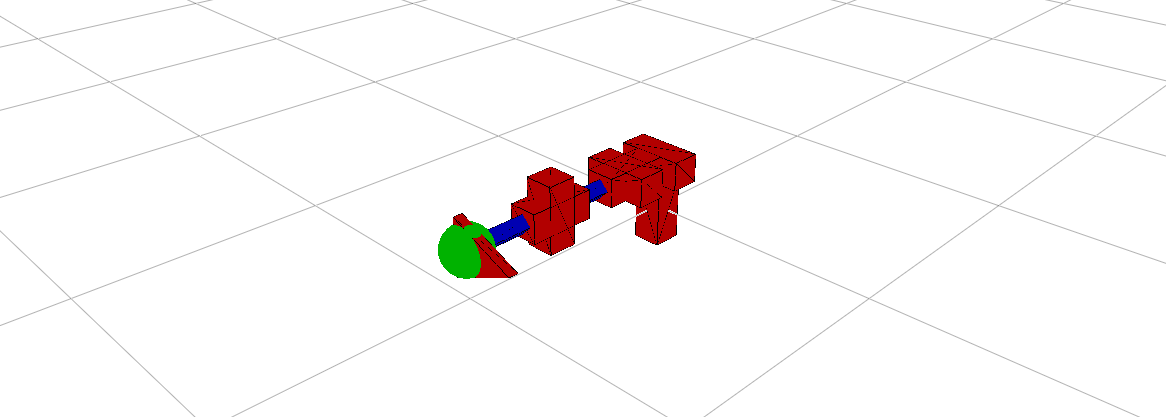

## Problem 3

Implement both the damped pseudo-inverse method and the Jacobian transpose method as
two different functions to solve the inverse kinematics problem. These should be implemented in your “kinematics.py” file, inside your SerialArm class. Start by copying the
skeleton of an ```ik_position``` function from ```kinematics_hw06.py```. To test these functions,
we will use the six degree of freedom robot from problem 2 and find an IK solution for just
a desired position (no orientation). This means your IK implementation only needs to use
the top three rows of the geometric Jacobian. 

Sections a)i. and a)ii. are each worth 12 points
when grading based on the difficulty of the problems. Please use the new ability to plot the
configuration of the robot to help you debug your IK algorithms. If the robot is not moving
towards to goal at each iteration of your algorithm this can help you track down the problem.

---

### (a) Using the positions defined in the table below: 

Do the following for both a starting joint configuration of:

- $ q_1 = [0, 0, 0, 0, 0, 0] $

and then again for a starting configuration of:

- $ q_2 = \left[ \frac{\pi}{4}, \frac{\pi}{4}, \frac{\pi}{4}, \frac{\pi}{4}, \frac{\pi}{4}, \frac{\pi}{4} \right] $

We have purposefully chosen 5 desired positions that should be reachable with this robot.

$$
\begin{array}{|c|c|c|c|}
\hline
\textbf{Desired Position} & \textbf{x} & \textbf{y} & \textbf{z} \\
\hline
1 & -0.149 & 0.364 & 1.03 \\
2 & -0.171 & -0.682 & -0.192 \\
3 & 0.822 & -0.1878 & 0.533 \\
4 & -0.336 & 0.095 & 0.931 \\
5 & 0.335 & 0.368 & 0.88 \\
\hline
\end{array}
$$

---


In [8]:
# define q1 and q2
q1 = [0] * 6
q2 = [np.pi/4] * 6
q_list = [q1, q2]

# define desired positions
goals = [[-0.149, 0.364, 1.03],
         [-0.171, -0.682, -0.192],
         [0.822, -0.1878, 0.533],
         [-0.336, 0.095, 0.931],
         [0.335, 0.368, 0.88]]

pos_list = [[tr.se3(p=np.array([i*2, 0, 0])) for i in range(len(goals))],
            [tr.se3(p=np.array([i*2, 2, 0])) for i in range(len(goals))]] # positions of each arm



arm3_list = [[kin.SerialArm(dh2, base=i, tip=Ttip) for i in pos_list[0]],
             [kin.SerialArm(dh2, base=i, tip=Ttip) for i in pos_list[1]]]

goals[0] + pos_list[1][1][0:3, 3]

goals_expanded = [[goals[i] + pos_list[0][i][0:3, 3] for i in range(5)],
                  [goals[i] + pos_list[1][i][0:3, 3] for i in range(5)]]
goals_expanded

[[array([-0.149,  0.364,  1.03 ]),
  array([ 1.829, -0.682, -0.192]),
  array([ 4.822 , -0.1878,  0.533 ]),
  array([5.664, 0.095, 0.931]),
  array([8.335, 0.368, 0.88 ])],
 [array([-0.149,  2.364,  1.03 ]),
  array([ 1.829,  1.318, -0.192]),
  array([4.822 , 1.8122, 0.533 ]),
  array([5.664, 2.095, 0.931]),
  array([8.335, 2.368, 0.88 ])]]

#### (i) Use damped pseudo-inverse method to find an inverse kinematics solution for your 5 goal positions starting from $q_1$ and $q_2$

---

In [9]:
# output = arm2.ik_position(goals[0], q1, K=np.eye(3))
# output2 = arm2.ik_position(goals[0], q2, K=np.eye(3))
# print(output)
# q_out = output[0]
# output = arm3_list[0][0].ik_position(goals[0], q_list[0], K=np.eye(3), method='pinv')

outputs = [[ arm3_list[0][i].ik_position(goals[i], q_list[0], K=np.eye(3), method='J_T') for i in range(len(goals)) ],
           [ arm3_list[1][i].ik_position(goals[i], q_list[1], K=np.eye(3), method='pinv') for i in range(len(goals)) ]]

q_out_list = [[ outputs[0][i][0] for i in range(len(outputs[0])) ],
              [ outputs[1][i][0] for i in range(len(outputs[1])) ]]

Target passes naive reach test, distance is 1e+00 and max reach is 1e+00
Target passes naive reach test, distance is 0.7 and max reach is 1e+00
Target passes naive reach test, distance is 1e+00 and max reach is 1e+00
Target passes naive reach test, distance is 1e+00 and max reach is 1e+00
Target passes naive reach test, distance is 1e+00 and max reach is 1e+00
Target passes naive reach test, distance is 1e+00 and max reach is 1e+00
Target passes naive reach test, distance is 0.7 and max reach is 1e+00
Target passes naive reach test, distance is 1e+00 and max reach is 1e+00
Target passes naive reach test, distance is 1e+00 and max reach is 1e+00
Target passes naive reach test, distance is 1e+00 and max reach is 1e+00


In [10]:
# goal = [0.1, 0.1, 0.1] # for x, y z position

viz = VizScene()

# add arms from initial position

for arm in arm3_list[0]:
    viz.add_arm(arm)

for i in range(len(arm3_list[0])):
    viz.add_arm(arm3_list[0][i], joint_colors=[np.array([1.0, 51.0/255.0, 51.0/255.0, 1])]*arm3_list[1][i].n)

for arm in arm3_list[1]:
    viz.add_arm(arm)

for i in range(len(arm3_list[0])):
    viz.add_arm(arm3_list[1][i], joint_colors=[np.array([1.0, 51.0/255.0, 51.0/255.0, 1])]*arm3_list[1][i].n)

for i in goals_expanded[0]:
    viz.add_marker(i)
for i in goals_expanded[1]:
    viz.add_marker(i)

viz.update(qs=[q_list[0] for i in range(5)] +\
              [q_out_list[0][i] for i in range(len(q_out_list[0]))] +\
              [q_list[1] for i in range(5)] +\
              [q_out_list[1][i] for i in range(len(q_out_list[1]))])
viz.hold()
viz.close_viz()

In [11]:
# # goal = [0.1, 0.1, 0.1] # for x, y z position
# q = [0, 0, 0, 0, 0, 0]

# viz = VizScene()
# viz.add_arm(arm2)
# viz.add_arm(arm2, joint_colors=[np.array([1.0, 51.0/255.0, 51.0/255.0, 1])]*arm2.n)
# viz.add_arm(arm2)
# viz.add_arm(arm2, joint_colors=[np.array([1.0, 51.0/255.0, 51.0/255.0, 1])]*arm2.n)
# viz.add_marker(goals[0])
# viz.update(qs=[q1, q_out, q2, output2[0]])
# viz.hold()
# viz.close_viz()

Damped pseudo-inverse:

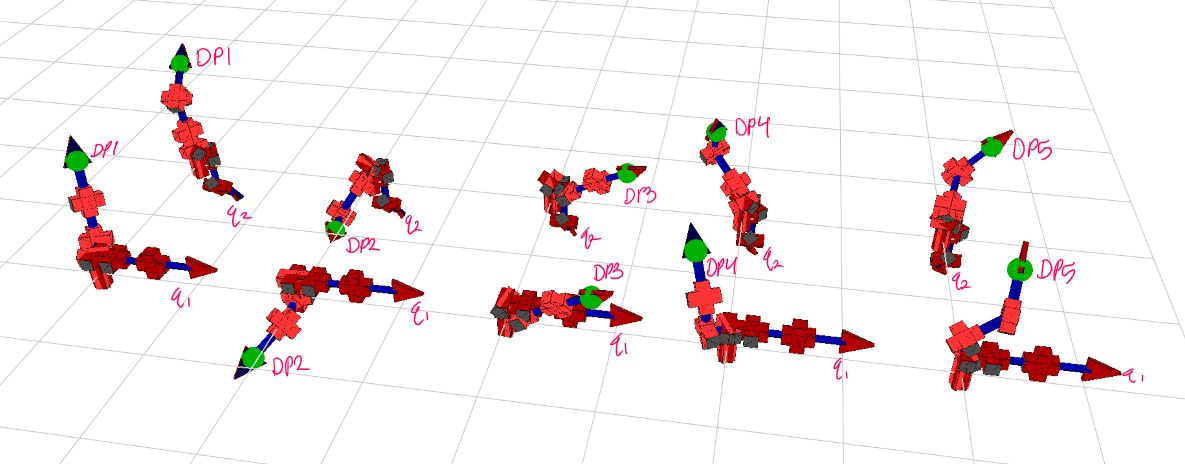

#### (b) 

Use the Jacobian transpose method to find an inverse kinematics solution for your
5 goal positions starting from q1 and q2

---

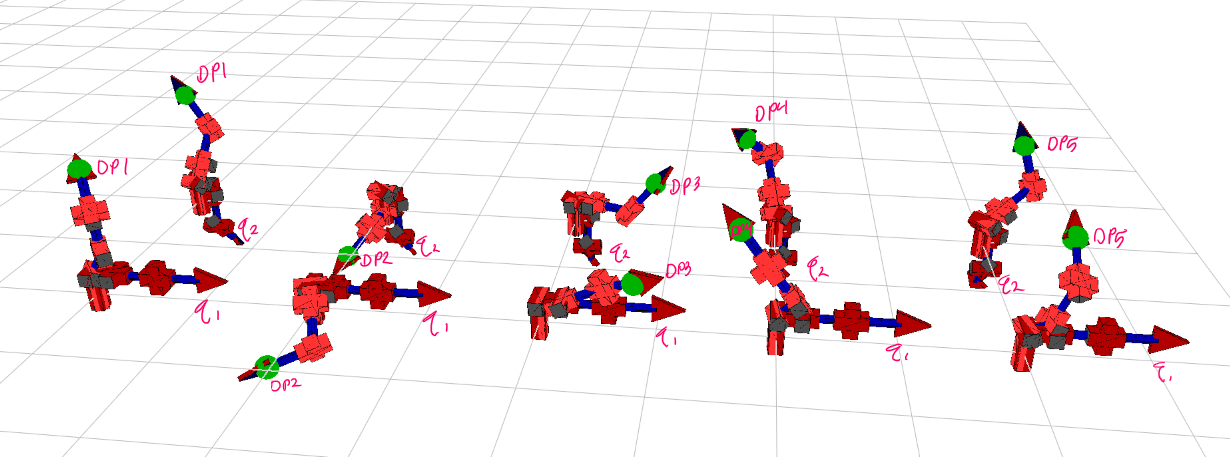

#### (c) 

Compare the solutions between your IK algorithms and the configuration that gave
you the original position. How are they different? Are there specific positions that
one or both algorithms failed to find from the given starting configurations? What
could you do about this? Turn in at least one plot/image/figure that shows the
joint configurations for all three (the original position joint angles and the two IK
method solutions). Also turn in your code and please keep this code and/or data
available as you will use it again in future assignments.

----

Both the damped pseudo-inverse method and the Jacobian transpose worked without errors. There is practically no difference between the methods, at least regarding the start and end positions. You can see for all 5 arms from two different starting points, both methods led the arms to pratically the same position. 